
 Random Forest Evaluation
R²: 0.696
MSE: 8137420433.60
RMSE: 90207.65
MAE: 62653.72
CV R² scores: [0.68949312 0.69824572 0.6937419  0.68531872 0.68954287]
Mean CV R²: 0.691
Mean CV MAE: 63845.33
Mean CV RMSE: 90957.80


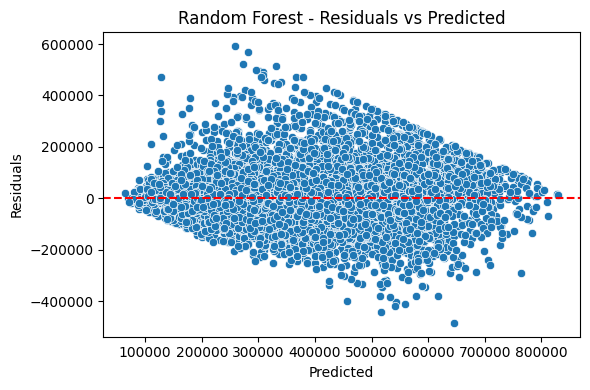

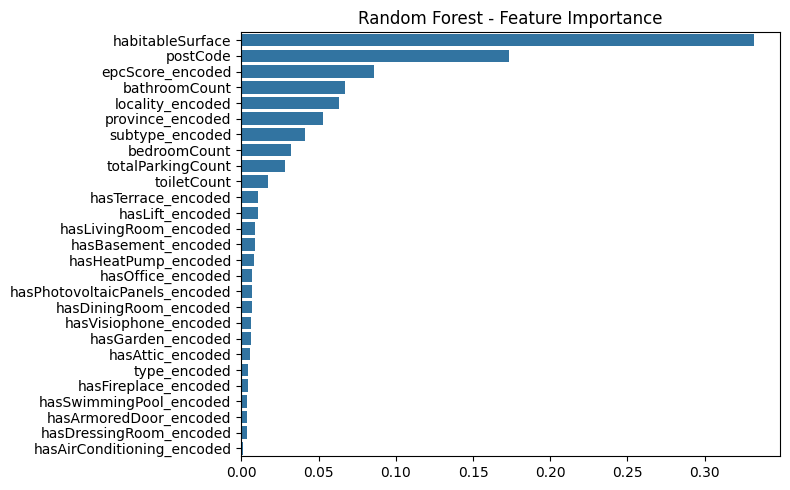


 Ridge Regression Evaluation
R²: 0.432
MSE: 15211573614.20
RMSE: 123335.21
MAE: 91737.39
CV R² scores: [ 0.43814929 -3.02203622  0.43816652  0.44097431  0.43075773]
Mean CV R²: -0.255
Mean CV MAE: 91802.18
Mean CV RMSE: 163290.66


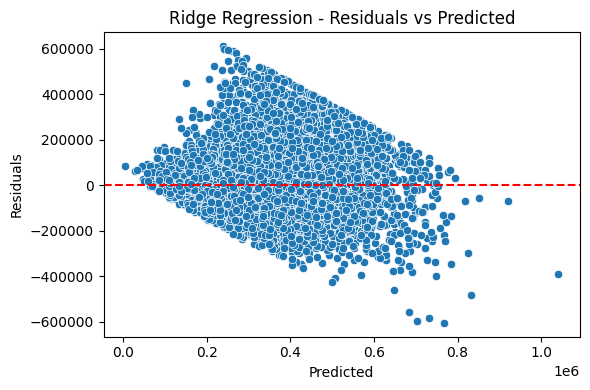


 XGBoost Evaluation
R²: 0.707
MSE: 7848630438.57
RMSE: 88592.50
MAE: 63167.54
CV R² scores: [0.70605681 0.71213837 0.71610914 0.70118949 0.70844804]
Mean CV R²: 0.709
Mean CV MAE: 63413.02
Mean CV RMSE: 88334.60


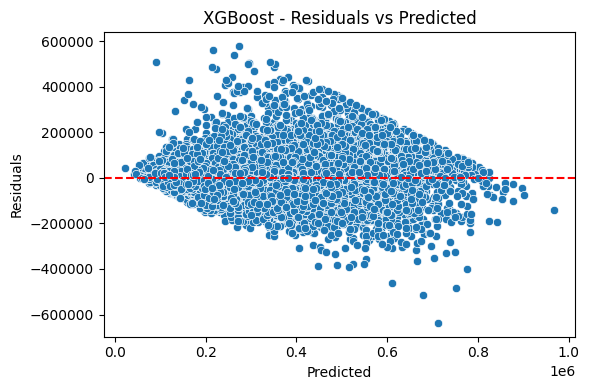

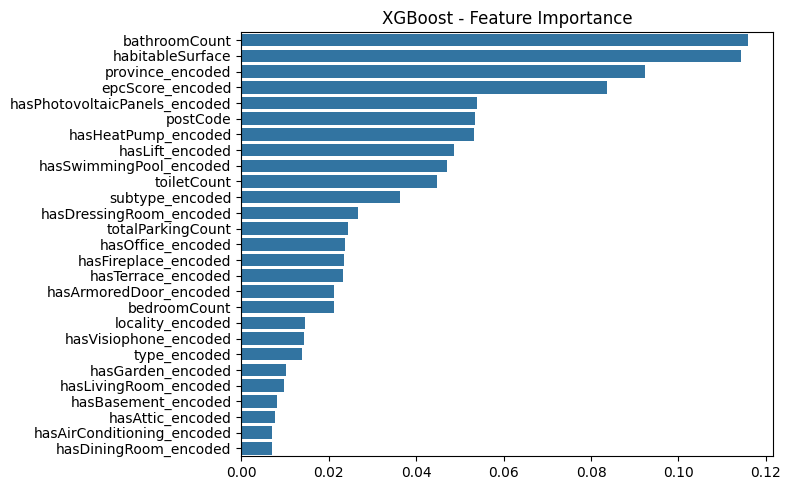

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 883
[LightGBM] [Info] Number of data points in the train set: 56164, number of used features: 27
[LightGBM] [Info] Start training from score 344210.449113

 LightGBM Evaluation
R²: 0.687
MSE: 8369716260.56
RMSE: 91486.15
MAE: 66123.04
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 882
[LightGBM] [Info] Number of data points in the train set: 44931, number of used features: 27
[LightGBM] [Info] Start training from score 344246.981327
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003759 secon

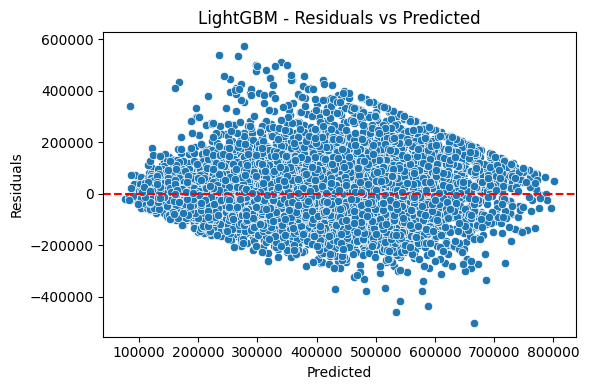

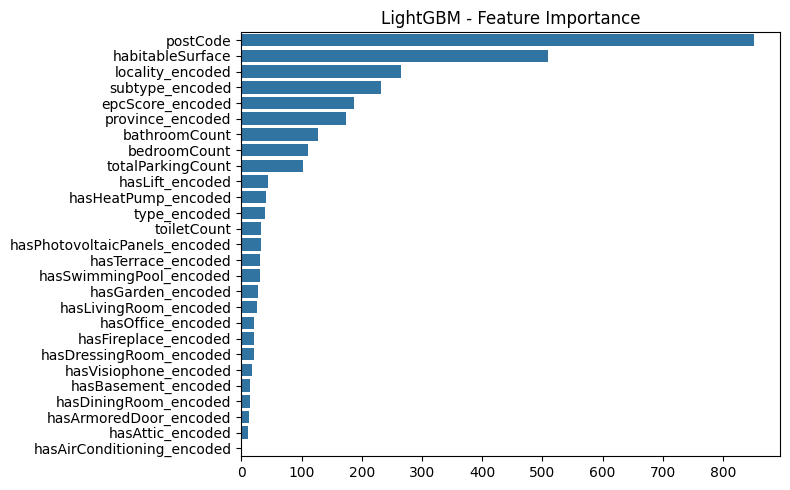


 Model Comparison Summary:
              Model     R²           MSE        RMSE        MAE  CV R²  \
2           XGBoost  0.707  7.848630e+09   88592.497  63167.545  0.709   
3          LightGBM  0.687  8.369716e+09   91486.153  66123.036  0.694   
0     Random Forest  0.696  8.137420e+09   90207.652  62653.721  0.691   
1  Ridge Regression  0.432  1.521157e+10  123335.208  91737.394 -0.255   

      CV MAE     CV RMSE  
2  63413.023   88334.600  
3  65666.957   90517.691  
0  63845.334   90957.805  
1  91802.176  163290.664  


In [2]:
# ml_model_evaluation.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Load dataset
df = pd.read_csv("dataset_wout_price_outliers.csv")

# Drop any nulls (you can handle better in production)
df = df.dropna()

# Target and features
target = 'price'
X = df.drop(columns=[target])
y = df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling (for models that need it)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store results
model_results = []

# Evaluation function
def evaluate_model(name, model, X_train, y_train, X_test, y_test,
                   X_train_scaled=None, X_test_scaled=None, scaled=False):
    print(f"\n {name} Evaluation")

    # Choose input
    X_train_eval = X_train_scaled if scaled else X_train
    X_test_eval = X_test_scaled if scaled else X_test

    # Predict
    y_pred = model.predict(X_test_eval)

    # Metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"R²: {r2:.3f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

    # CV metrics
    cv_r2 = cross_val_score(model, X_train_eval, y_train, cv=5, scoring='r2')
    cv_mae = -cross_val_score(model, X_train_eval, y_train, cv=5, scoring='neg_mean_absolute_error')
    cv_rmse = np.sqrt(-cross_val_score(model, X_train_eval, y_train, cv=5, scoring='neg_mean_squared_error'))

    print(f"CV R² scores: {cv_r2}")
    print(f"Mean CV R²: {cv_r2.mean():.3f}")
    print(f"Mean CV MAE: {cv_mae.mean():.2f}")
    print(f"Mean CV RMSE: {cv_rmse.mean():.2f}")

    # Save metrics
    model_results.append({
        "Model": name,
        "R²": r2,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "CV R²": cv_r2.mean(),
        "CV MAE": cv_mae.mean(),
        "CV RMSE": cv_rmse.mean()
    })

    # Residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{name} - Residuals vs Predicted")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    # Feature importance
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        try:
            features = X_train.columns
        except:
            features = df.drop(columns=[target]).columns
        sorted_idx = np.argsort(importance)[::-1]
        plt.figure(figsize=(8, 5))
        sns.barplot(x=importance[sorted_idx], y=np.array(features)[sorted_idx])
        plt.title(f"{name} - Feature Importance")
        plt.tight_layout()
        plt.show()


# Train models
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
evaluate_model("Random Forest", rf_model, X_train, y_train, X_test, y_test)

ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
evaluate_model("Ridge Regression", ridge_model, X_train, y_train, X_test, y_test,
               X_train_scaled=X_train_scaled, X_test_scaled=X_test_scaled, scaled=True)

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
evaluate_model("XGBoost", xgb_model, X_train, y_train, X_test, y_test)

lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)
evaluate_model("LightGBM", lgbm_model, X_train, y_train, X_test, y_test)

# Summary comparison
results_df = pd.DataFrame(model_results)
print("\n Model Comparison Summary:")
print(results_df.sort_values(by="CV R²", ascending=False).round(3))